In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from specim.specfuncs import spec1d

In [2]:
data =  spec1d.Spec1d('../RXJ1131_spec.fits', informat='mwa')
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']


Reading spectrum from ../RXJ1131_spec.fits
Expected file format: mwa
 Spectrum Start:  5020.78
 Spectrum End:     8219.18
 Dispersion (1st pixel):   0.80
 Dispersion (average):      0.80



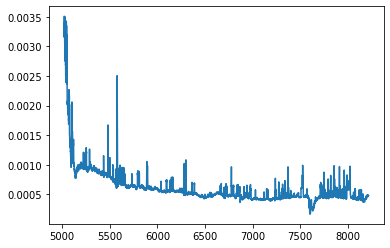

In [3]:
#%matplotlib notebook
plt.plot(lamda_galaxy, variance_spectra_galaxy)

### Below is the list of emission lines (in terms of wavelength) we would like to fit with a Gaussian distribution. The tuples contains start and end value of the wavelength range for thses emission lines. However they are not the exact wavelength data points in the spectra as we have collected these wavelength values from the zoomed out plot of the emission lines. So we have to replace these wavelength values with the closest wavelengths values from the spectra.

In [4]:
emission_lines = [(5222.36, 5223.99), (5251.16, 5255.98), (5286.38, 5287.99), (5434.34, 5436.17),
                  (5479.04, 5485.16), (5496.74, 5502.49), (5530.01, 5534.49), (5573.39, 5581.98),
                  (5646.79, 5652.15), (5800.77, 5811.93), (6091.94, 6101.64), (6146.86, 6148.82),
                  (6295.94, 6304.79), (6360.53, 6368.14), (6668.21, 6673.39), (6720.64, 6725.75),
                  (6775.97, 6781.59), (6793.08, 6803.17), (7028.67, 7032.81), (7143.81, 7155.07),
                  (7271.46, 7280.36), (7364.82, 7381.76), (7747.07, 7755.18), (7817.56, 7825.60),
                  (7909.53, 7916.84), (7961.31, 7967.21), (8074.97, 8081.67)]

In [5]:
exact_emission_lines = []
index = []
for i,p in enumerate(emission_lines):
    a = abs(lamda_galaxy - p[0])
    b = abs(lamda_galaxy - p[1])
    a_list = a.tolist()
    b_list = b.tolist()
    start = lamda_galaxy[a_list.index(min(a))]
    stop = lamda_galaxy[b_list.index(min(b))]
    exact_emission_lines.append((start, stop))
    index.append((a_list.index(min(a)), b_list.index(min(b))))

In [6]:
print("emission_lines : \n")
[print(*line) for line in emission_lines]
print("\nexact_emission_lines : \n")
[print(*line) for line in exact_emission_lines]

emission_lines : 

5222.36 5223.99
5251.16 5255.98
5286.38 5287.99
5434.34 5436.17
5479.04 5485.16
5496.74 5502.49
5530.01 5534.49
5573.39 5581.98
5646.79 5652.15
5800.77 5811.93
6091.94 6101.64
6146.86 6148.82
6295.94 6304.79
6360.53 6368.14
6668.21 6673.39
6720.64 6725.75
6775.97 6781.59
6793.08 6803.17
7028.67 7032.81
7143.81 7155.07
7271.46 7280.36
7364.82 7381.76
7747.07 7755.18
7817.56 7825.6
7909.53 7916.84
7961.31 7967.21
8074.97 8081.67

exact_emission_lines : 

5222.383203120053 5223.983203120053
5251.183203120059 5255.98320312006
5286.383203120067 5287.983203120068
5434.383203120101 5435.983203120101
5479.183203120111 5484.783203120112
5496.783203120115 5502.383203120116
5530.383203120123 5534.383203120124
5573.583203120133 5581.583203120134
5647.183203120149 5651.98320312015
5800.783203120184 5811.983203120187
6091.98320312025 6101.583203120253
6147.183203120263 6148.783203120263
6295.983203120297 6304.783203120299
6360.783203120312 6367.983203120313
6667.983203120381 6673.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [7]:
# empty list to contain data of these emission lines 
data_emission = []           
lamda_emission = [] 

### Collecting the variance on spectra data for specific range of wavelengths of the emission lines to fit with Gaussian distribution.

In [8]:
lam_list = lamda_galaxy.tolist()                   # converting array to list
var_spec_list = variance_spectra_galaxy.tolist()   # contains variance on spectra data

for i,p in enumerate(exact_emission_lines):
    start = lam_list.index(p[0])
    stop  = lam_list.index(p[1])
    var_spec = var_spec_list[start:stop+1]   # slicing and collecting data for the wavelength range
    lam = lam_list[start:stop+1]
    data_emission.append(var_spec)
    lamda_emission.append(lam)

### Here is the plot of emission lines we are going to fit

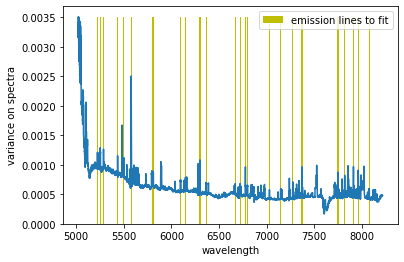

In [9]:
s = np.zeros(len(lamda_emission))
w = np.zeros(len(lamda_emission))
for i,p in enumerate(lamda_emission):
    s[i]= np.median(p)
    w[i]= len(p)

plt.plot(lamda_galaxy, variance_spectra_galaxy)
plt.bar(s, height=max(variance_spectra_galaxy), width=w, color='y', label='emission lines to fit')
plt.xlabel('wavelength')
plt.ylabel('variance on spectra')
plt.legend()
plt.show()

In [10]:
model_gauss = models.Gaussian1D()           # calling the Gaussian model 
fitter_gauss = fitting.LevMarLSQFitter()    # Calling the fitting scheme 

###  Here we are going to fit each emission line data individually. Before fit we have normalized the flux with the median value of the data of each emission lines. Then we have shifted both the x and y axis of the data. The y axis has been shifted by subtracting the minimum value of the data array so that it touch the x axis. And the x axis has been shifted by the median value of the data array.

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev      
    ------------------ ------------------ ------------------
    0.4086797353937019 0.1661702610910627 0.2038666201416868


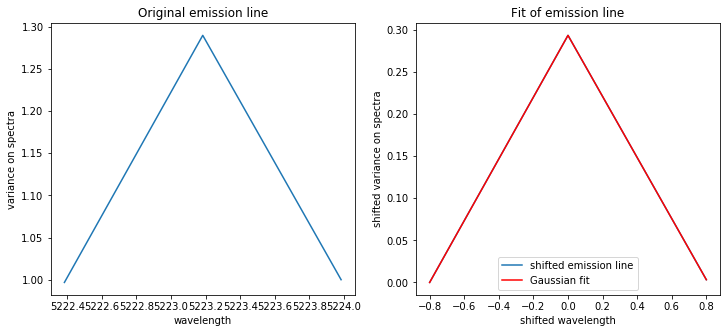

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude              mean              stddev      
    ------------------- ------------------- ------------------
    0.31510687149024513 0.19426265715070173 1.2344245323171525


<Figure size 432x288 with 0 Axes>

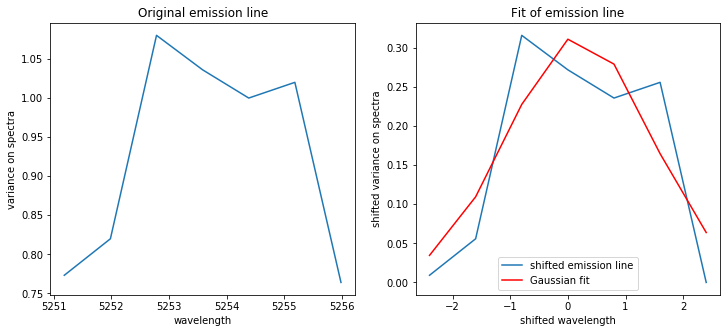

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev      
    ------------------ ------------------ ------------------
    0.7449886816126466 0.2611608369995059 0.2197344327683453


<Figure size 432x288 with 0 Axes>

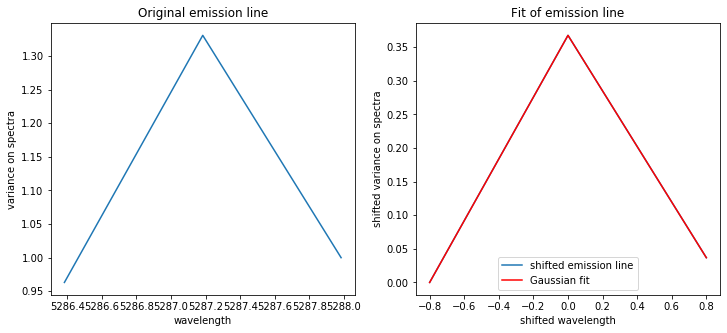

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ ------------------- -------------------
    0.6738948344160025 0.22574736033292328 0.21067043716482614


<Figure size 432x288 with 0 Axes>

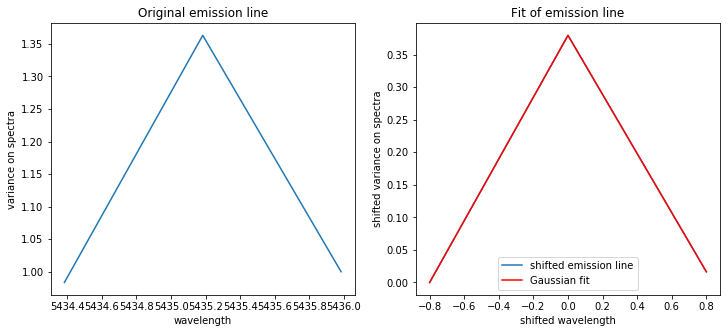

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    0.5632740148716545 -0.26037813969394896 1.1788598343242724


<Figure size 432x288 with 0 Axes>

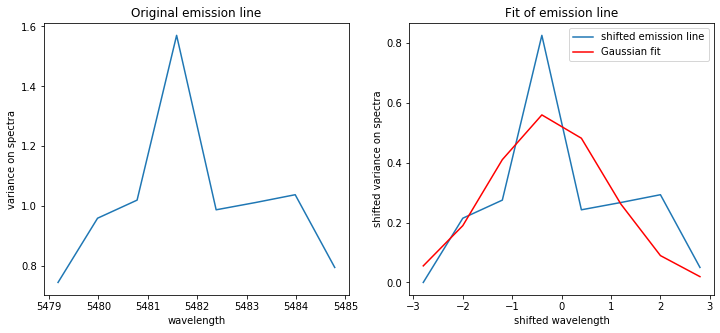

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev     
    ------------------ -------------------- -----------------
    0.3810731622563784 -0.06805563336969424 1.170226846226739


<Figure size 432x288 with 0 Axes>

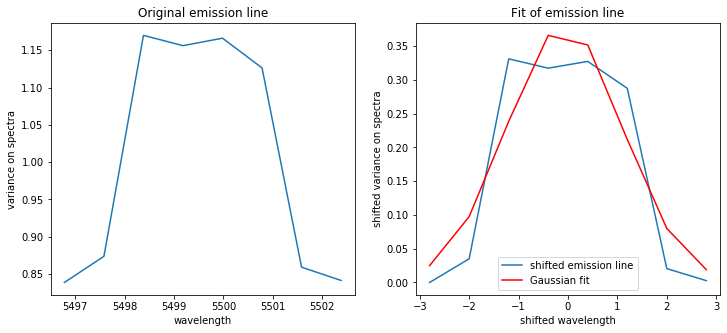

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude               mean               stddev      
    ------------------ --------------------- ------------------
    0.3183649056332907 -0.029273210420129665 1.0751492840878065


<Figure size 432x288 with 0 Axes>

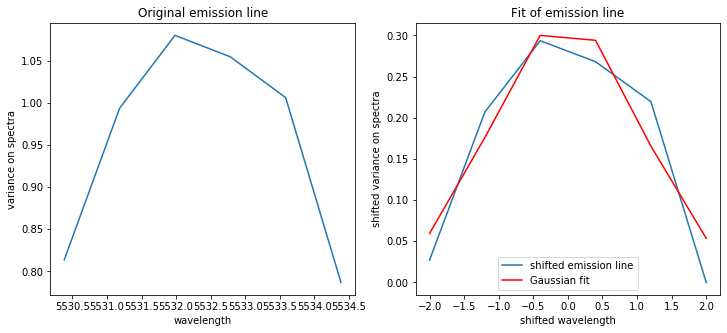

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    1.5068355022457733 -0.19091035009584467 1.4870807357549165


<Figure size 432x288 with 0 Axes>

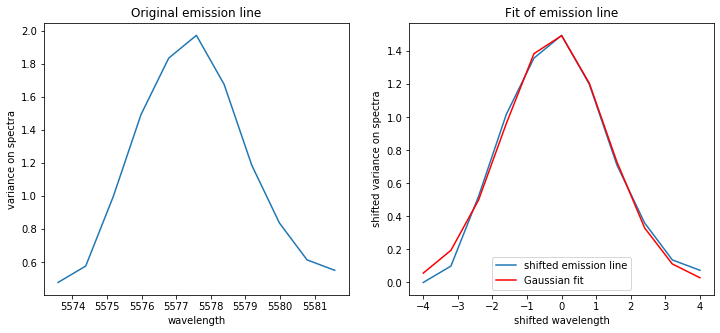

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude              mean               stddev      
    ------------------- -------------------- ------------------
    0.30250193228947453 -0.07144595760471802 1.5798624892187496


<Figure size 432x288 with 0 Axes>

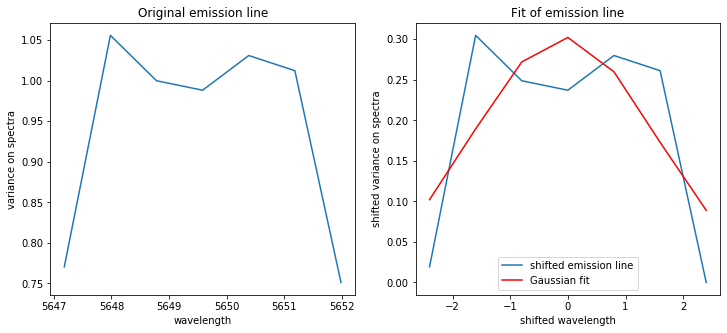

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ------------------ ------------------ -----------------
    0.3263884896301969 0.6204026726203938 3.855053889357979


<Figure size 432x288 with 0 Axes>

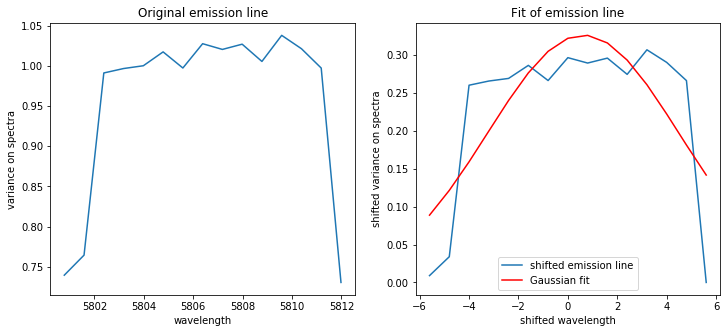

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    0.2977306989019476 -0.01185118757751539 3.7332474438704657


<Figure size 432x288 with 0 Axes>

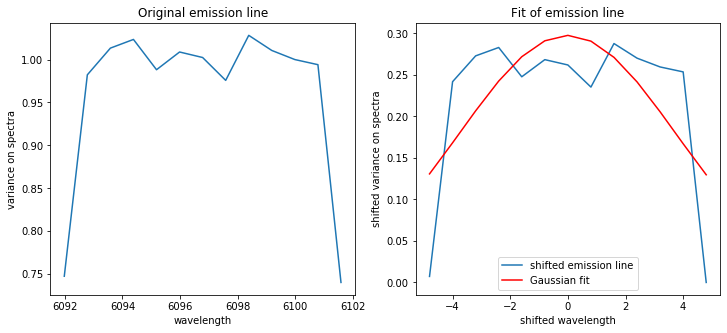

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    0.6196017308283537 -0.2197046104512182 0.2121864455510675


<Figure size 432x288 with 0 Axes>

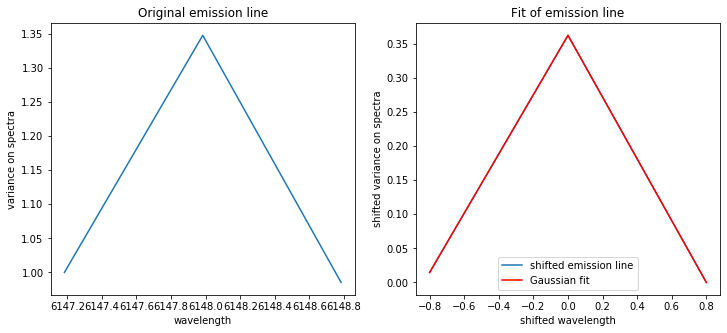

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    0.8639319690034882 -0.08303239510669466 1.5770211763502617


<Figure size 432x288 with 0 Axes>

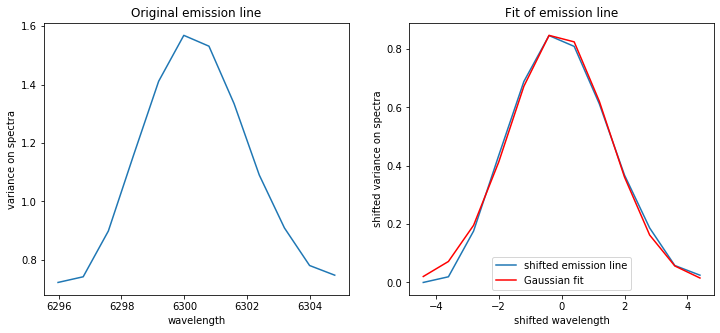

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    0.3458860639709111 -0.5683543977125337 1.7215351985774818


<Figure size 432x288 with 0 Axes>

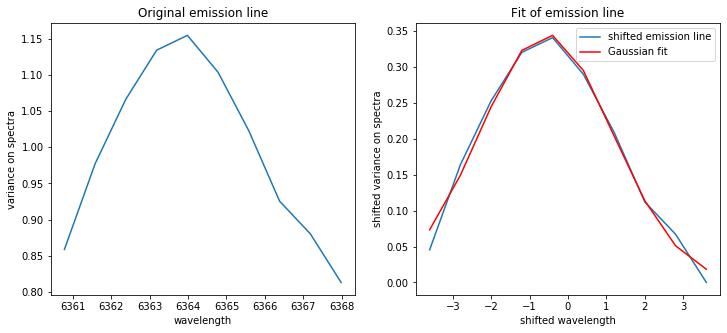

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev      
    ------------------ ------------------ ------------------
    0.4356154044002971 0.4650324764548143 0.8954807358060427


<Figure size 432x288 with 0 Axes>

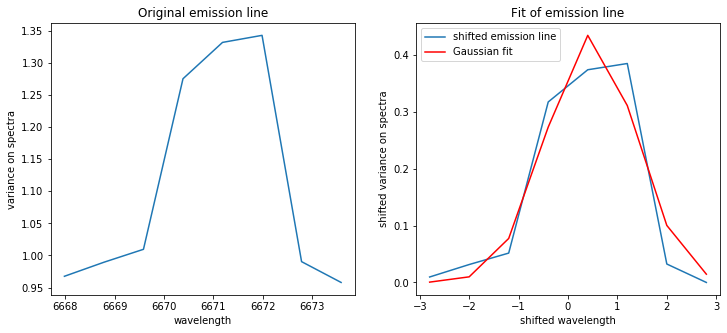

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    0.3235980820935819 -0.09222550106765998 1.4933380414966213


<Figure size 432x288 with 0 Axes>

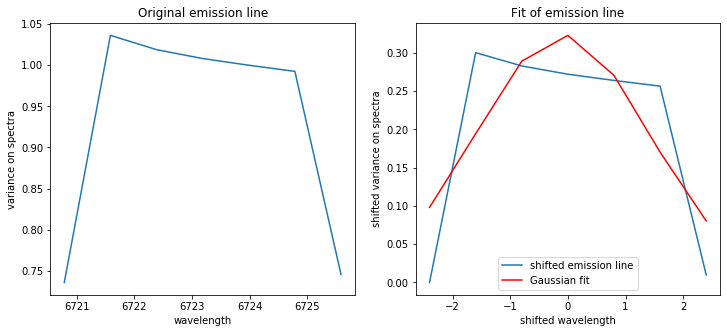

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    0.5158336188125848 -0.27634760166930566 1.2366817362056228


<Figure size 432x288 with 0 Axes>

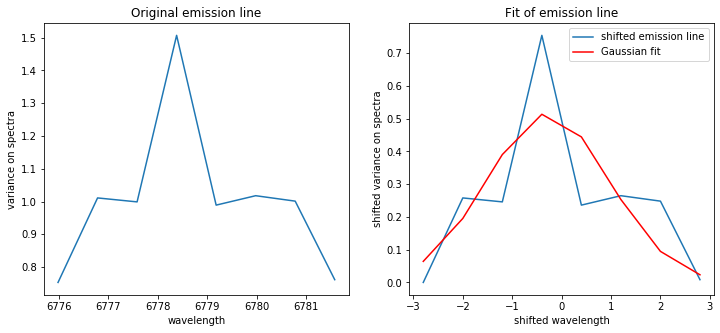

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             mean              stddev     
    ------------------- ------------------ -----------------
    0.31702917430927935 0.8234339612339019 3.063782828339102


<Figure size 432x288 with 0 Axes>

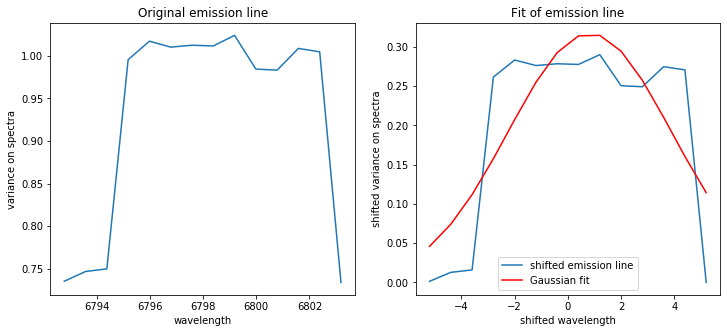

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    0.3304412030434331 -0.06445825118142066 1.1084036738362895


<Figure size 432x288 with 0 Axes>

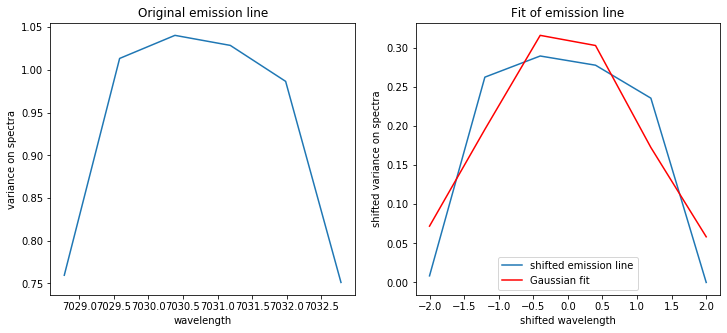

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean             stddev     
    ------------------ ------------------ ----------------
    0.3257488431358237 0.3671478801553763 2.45043557301869


<Figure size 432x288 with 0 Axes>

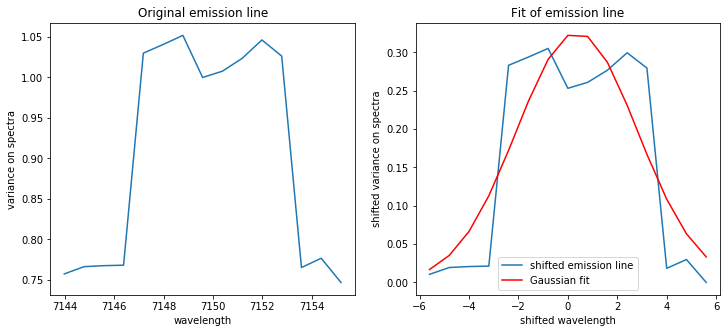

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev      
    ------------------ ------------------ ------------------
    0.6080876304166865 0.5990085837457819 1.4589188292906483


<Figure size 432x288 with 0 Axes>

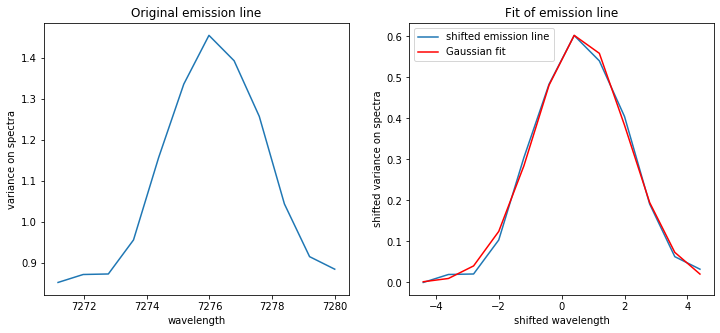

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ------------------ ------------------ -----------------
    0.4345414798469216 0.4153733915560267 4.520286109983738


<Figure size 432x288 with 0 Axes>

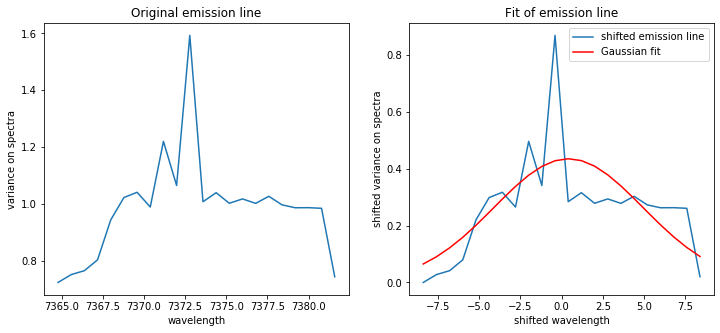

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    0.8331362635101065 -0.6136843872943817 1.3350103469676535


<Figure size 432x288 with 0 Axes>

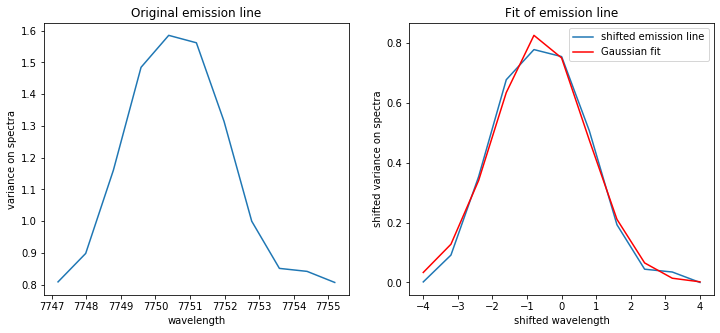

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    0.7269354352820391 -0.12531824807134243 1.3552110212308017


<Figure size 432x288 with 0 Axes>

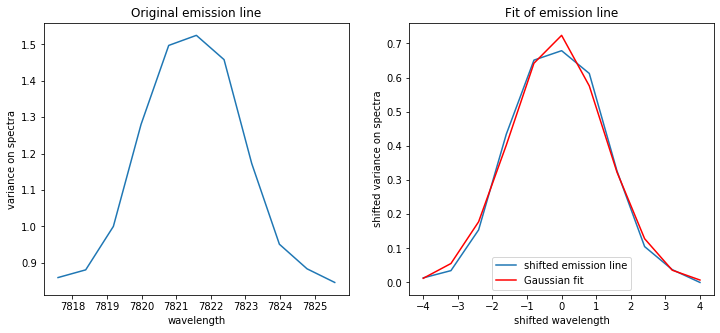

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ------------------ ------------------ -----------------
    0.8447514991246754 0.3339210220403469 1.390732945317765


<Figure size 432x288 with 0 Axes>

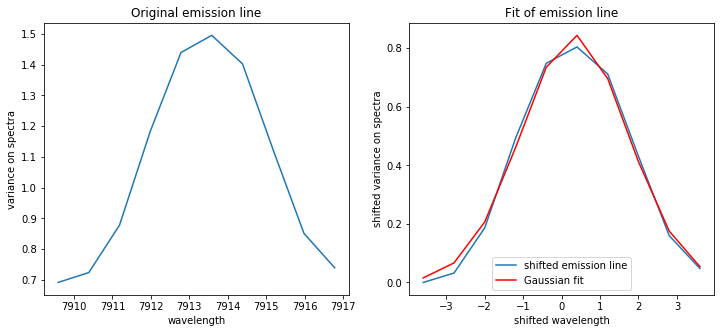

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude               mean               stddev      
    ------------------ --------------------- ------------------
    0.6357928561040359 -0.012738154324285848 1.3791451467546427


<Figure size 432x288 with 0 Axes>

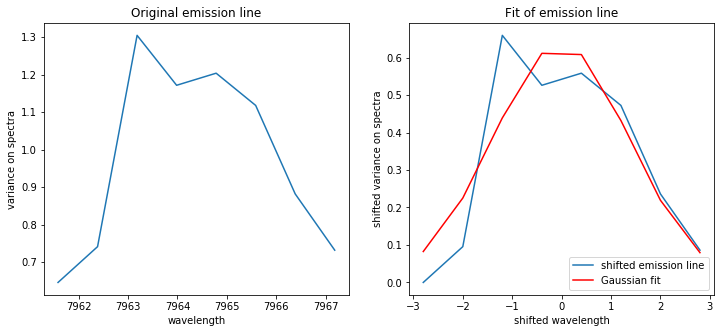

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             mean              stddev     
    ------------------- ------------------ -----------------
    0.32402057747859725 -0.176101670387132 2.168243665359552


<Figure size 432x288 with 0 Axes>

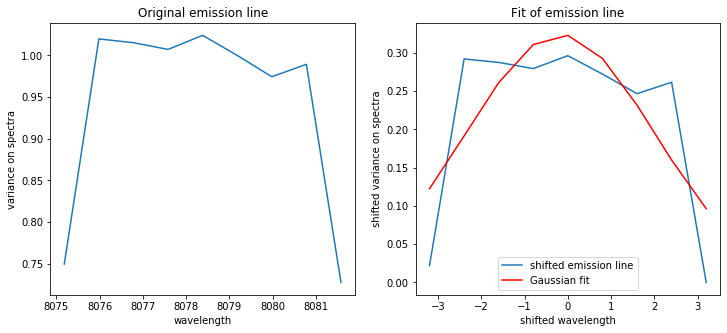

<Figure size 432x288 with 0 Axes>

In [11]:
best_fit = []
for i,p in enumerate(data_emission):
    data_emission[i] = data_emission[i] / np.median(data_emission[i])
    x= lamda_emission[i] - np.median(lamda_emission[i])
    y= data_emission[i] - np.min(data_emission[i])
    
    best_fit_gauss = fitter_gauss(model_gauss, x, y)
    best_fit.append(best_fit_gauss)
    
    print(best_fit_gauss)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(lamda_emission[i], data_emission[i])
    ax1.set_title('Original emission line')
    ax1.set_xlabel('wavelength')
    ax1.set_ylabel('variance on spectra')
    
     
    ax2.plot(x, y, label='shifted emission line') 
    ax2.plot(x, best_fit_gauss(x), 'r', label='Gaussian fit')
    ax2.set_title('Fit of emission line')
    ax2.set_xlabel('shifted wavelength')
    ax2.set_ylabel('shifted variance on spectra')
    plt.legend()
    plt.show()
    plt.figure()

In [12]:
# Calculating the average value of the std_dev.
s= 0
for i,p in enumerate(best_fit):
    s += p.stddev.value
    #print(i)
print('average : %f' %((s)/ i))

average : 1.665946
